## Importing files


In [ ]:
!git clone https://github.com/ceyxasm/computer_vision.git

Cloning into 'computer_vision'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 308 (delta 34), reused 190 (delta 24), pack-reused 108
Receiving objects: 100% (308/308), 65.68 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (36/36), done.


#Assignment 2-A

##Question 1: 
You are given a scene image containing logo, and a gallery containing refer-
ence logos for 10 business brands. Find out which business brand is present
in the scene. Try out three different approaches and compare them.

computer_vision  sample_data


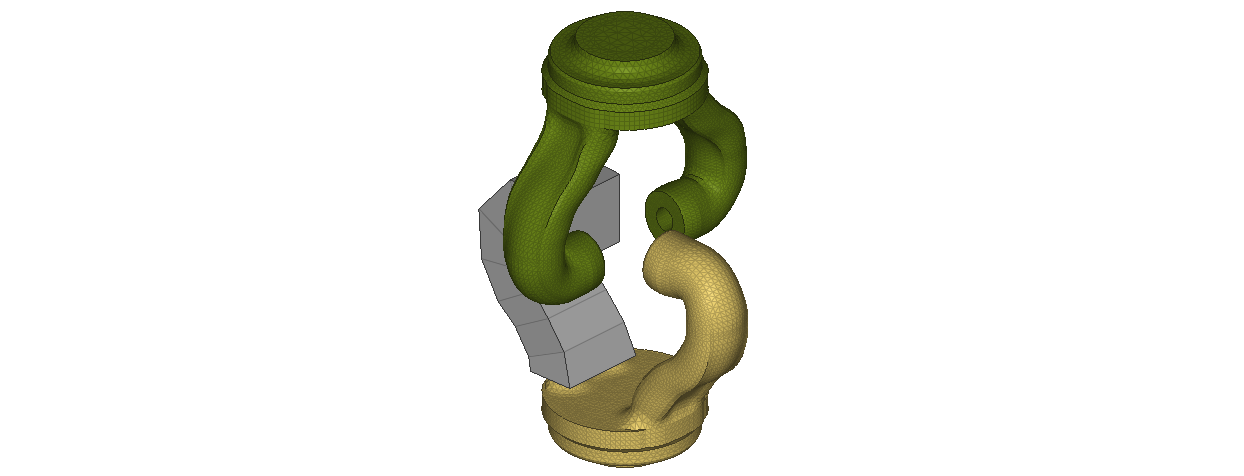

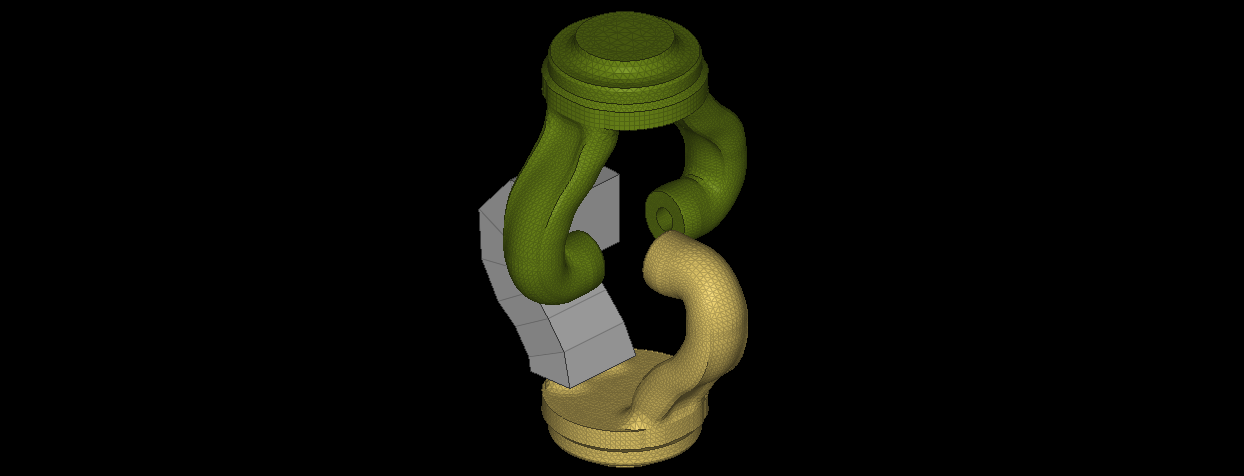

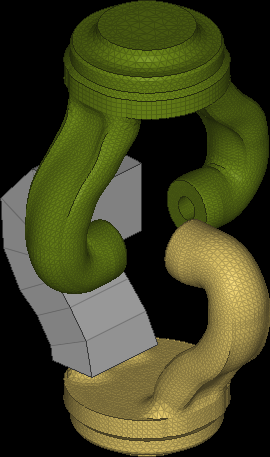

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
img = cv2.imread('/content/computer_vision/csl7360/A2/Assignment-2/Problem-3/example-2/Orginal.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary mask
ret, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

# Invert the mask
mask = cv2.bitwise_not(mask)

# Apply the mask to the image
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Find the contours of the masked image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create a bounding box around the contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the image to the bounding box
cropped_img = masked_img[y:y+h, x:x+w]

# Show the original image, the masked image, and the cropped image
cv2_imshow(img)
cv2_imshow( masked_img)
cv2_imshow(cropped_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Panorama

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)

# Global Variables
feature_extractor = 'sift'
feature_matching = 'bf'
# Number of images
n = 3



In [ ]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [ ]:
def showKeypoints(img1, img2, kpsA, kpsB):
    # display the keypoints and features detected on both images
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    ax1.imshow(cv2.drawKeypoints(img1,kpsA,None,color=(0,255,0)))
    ax1.set_xlabel("(a)", fontsize=14)
    ax2.imshow(cv2.drawKeypoints(img2,kpsB,None,color=(0,255,0)))
    ax2.set_xlabel("(b)", fontsize=14)

    plt.show()

In [ ]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [ ]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [ ]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [ ]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
def showFeatureMatch(img1, img2, kpsA, kpsB, featuresA, featuresB):
    fig = plt.figure(figsize=(20,8))

    if feature_matching == 'bf':
        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches[:100],
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,np.random.choice(matches,100),
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.axis('off')
    plt.show()
    return matches

In [ ]:
def hStich(img1, img2, H):
    # Apply a horizontal panorama
    width = img2.shape[1] + img1.shape[1]
    height = max(img2.shape[0], img1.shape[0])
    # otherwise, apply a perspective warp to stitch the images
    # together
    result = cv2.warpPerspective(img1, H, (width, height))
    result[0:img2.shape[0], 0:img2.shape[1]] = img2

    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(result)
    plt.show()
    return result

In [ ]:
def hStich2(image1, image2, H):
  # Resize the images to the same size
  height, width = image1.shape[:2]
  image2 = cv2.resize(image2, (width, height))

  # Compute the homography matrix (for example, using OpenCV's findHomography function)
  homography = H
  # Warp the second image using the homography matrix
  stitched_image = cv2.warpPerspective(image2, homography, (width, height))

  # Combine the two images
  stitched_image[:height, :width] = image1

  # Save the result
  plt.figure(figsize=(20,10))
  plt.axis('off')
  plt.imshow(stitched_image)
  plt.show()
  return stitched_image


In [ ]:
def combine(img1, img2):
    kpsA, featuresA = detectAndDescribe(img1, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(img2, method=feature_extractor)

    showKeypoints(img1, img2, kpsA, kpsB)
    print("Using: {} feature matcher".format(feature_matching))
    matches = showFeatureMatch(img1, img2, kpsA, kpsB, featuresA, featuresB)

    # Homography of the images
    M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
    if M is None:
        print("Error!")
    (matches, H, status) = M
    print(H)

    # Applyiing horizontal stiching
    himg = hStich(img1, img2, H)
    return himg

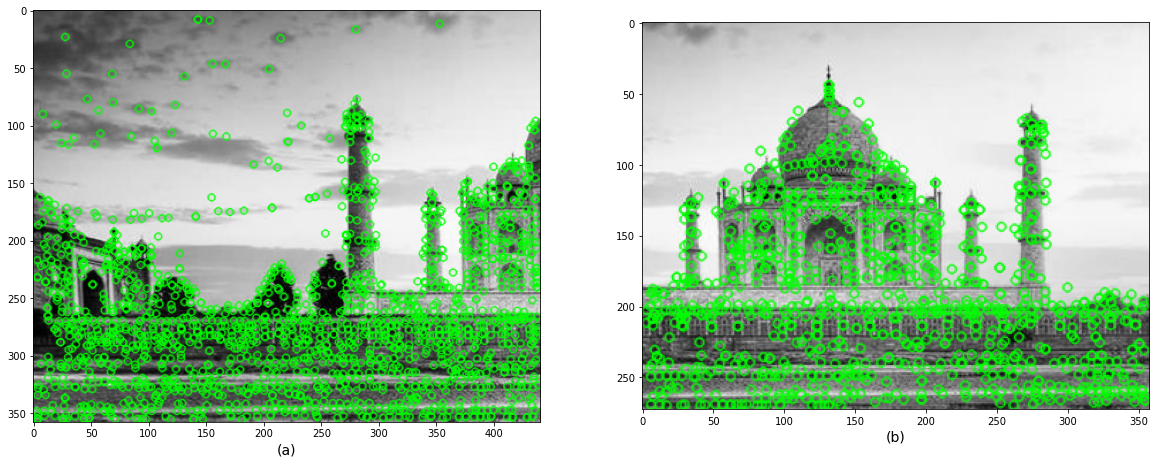

Using: bf feature matcher
Raw matches (Brute force): 430


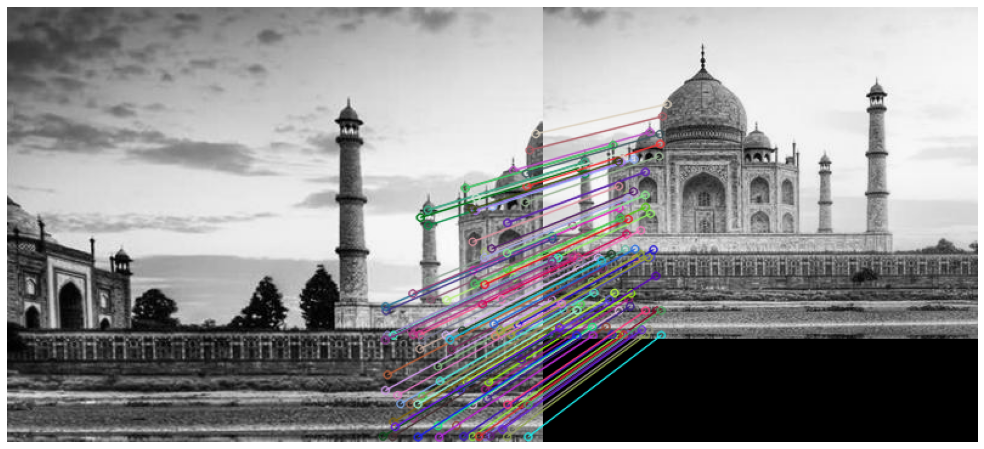

[[ 7.59467983e-01 -1.17571989e-03 -2.28666040e+02]
 [-2.72663173e-03  7.59670941e-01  1.07513582e+00]
 [-1.06464600e-05 -2.16917566e-06  1.00000000e+00]]


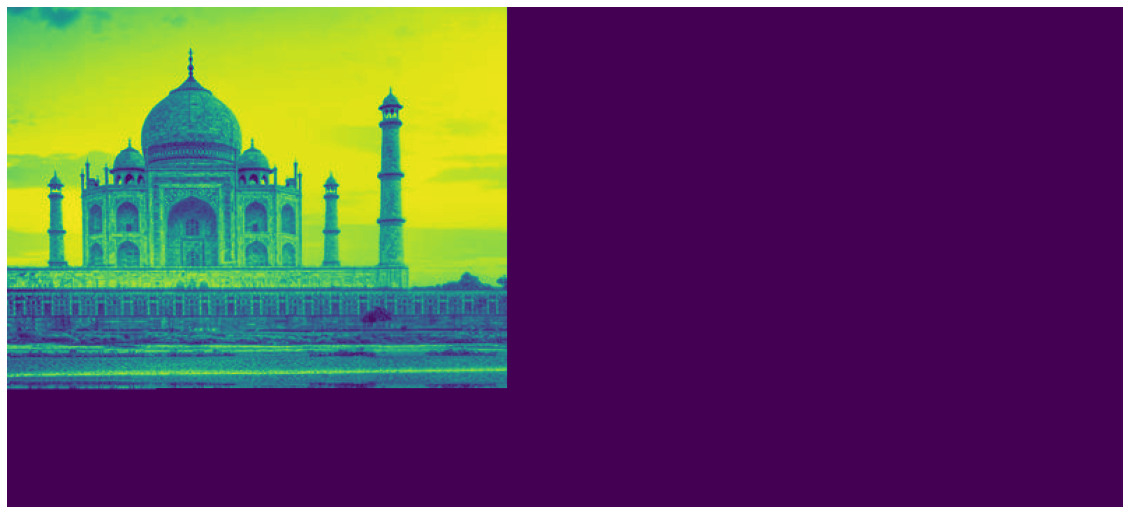

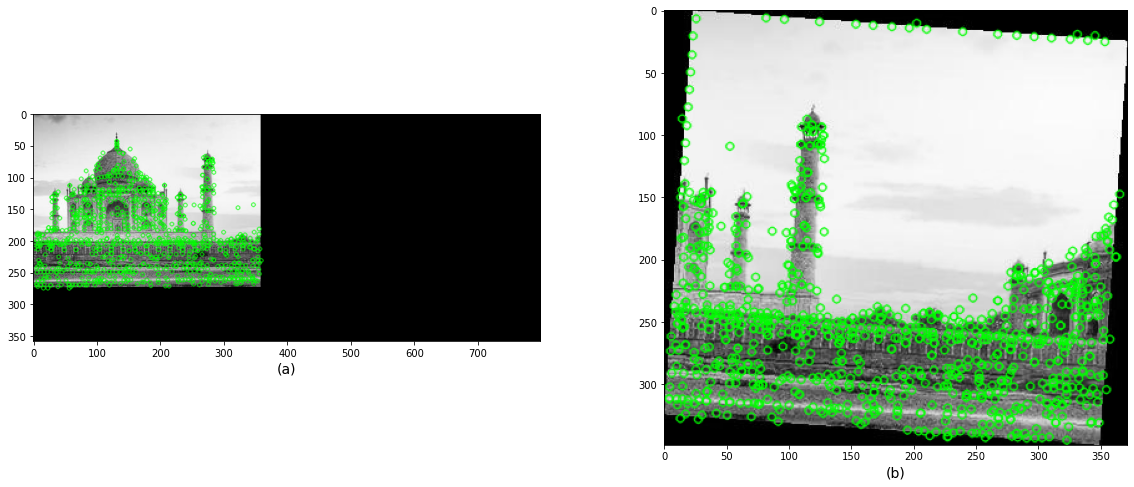

Using: bf feature matcher
Raw matches (Brute force): 338


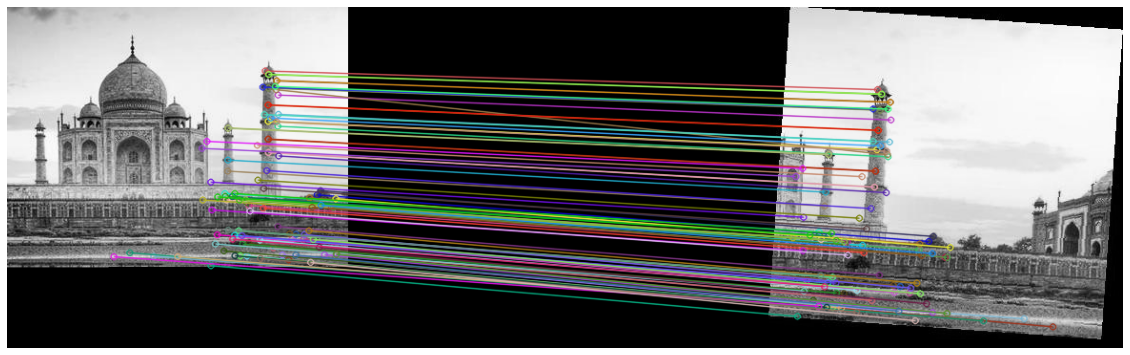

[[ 1.19040286e+00 -8.20976940e-02 -2.02532328e+02]
 [ 8.30080466e-02  1.18825511e+00 -1.54935353e+01]
 [-1.39996564e-06  3.20422784e-06  1.00000000e+00]]


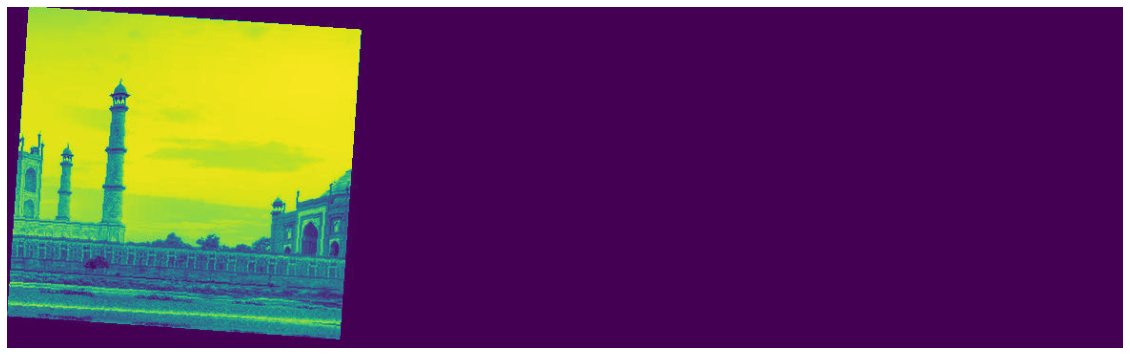

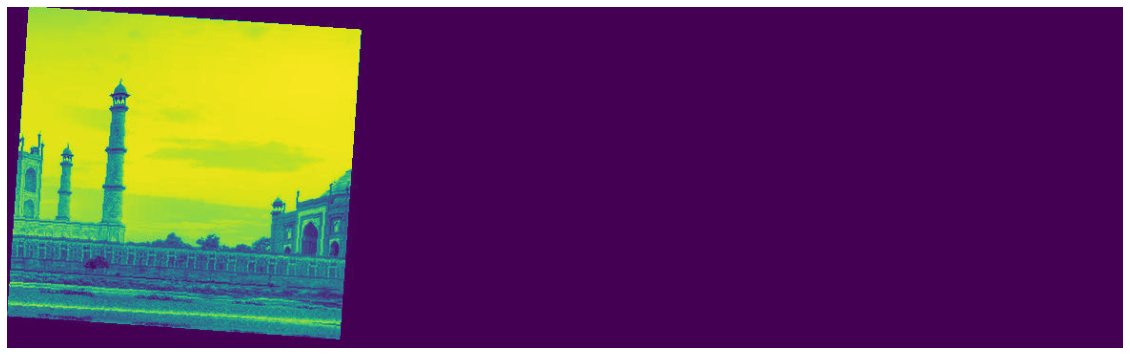

In [ ]:
img1 = cv2.imread('1a.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

img_map = img1
labels = ['b', 'c']
img_map_gray = img1_gray
for i in labels:
    path = '1{}.jpeg'
    img = cv2.imread(path.format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_map_gray = combine(img_map_gray, img_gray)

# Plotting the final image_map
plt.figure(figsize=(20,10))
plt.imshow(img_map_gray)
plt.axis('off')
plt.show()